In [1]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
from pennylane import numpy as np

import sys
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnn as qcnn
import visualization as qplt
import losses
import general as qmlgen

In [2]:
Ns = [4,6,8,10,12]
side = 100


In [3]:
path = '../data/vqes/ANNNI/'
pathplots = '../data/plots/'

train_index_line  = np.arange(0,2*side-1)
train_index_edges = np.array([0,side-1,2*side-1])

In [4]:
vqes = []
for N in Ns:
    try:
        filename = 'N'+str(N)+'n'+str(side)
        vqes.append(vqe.load_vqe(path + filename) )
        print('{0} loaded sucessfully'.format(path+filename))
    except:
        print('{0} not found'.format(path+filename))

../data/vqes/ANNNI/N4n100 loaded sucessfully
../data/vqes/ANNNI/N6n100 loaded sucessfully
../data/vqes/ANNNI/N8n100 loaded sucessfully
../data/vqes/ANNNI/N10n100 loaded sucessfully
../data/vqes/ANNNI/N12n100 loaded sucessfully


In [5]:
cents = qmlgen.findC(*vqes[:-1], width = .15)

In [3]:
import numpy as np

In [6]:
with np.errstate(divide='ignore', invalid='ignore'):
    a = 1/np.arange(10)

In [6]:
lr = .05
epoch = 2000

Cost: 0.09102962911128998: 100%|██████████| 2000/2000 [00:25<00:00, 79.34it/s] 


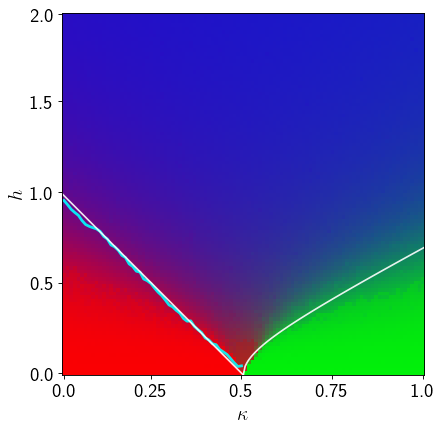

In [10]:
myqcnn = qcnn.qcnn(vqes[1], qcnn.qcnn_circuit, n_outputs = 2)
myqcnn.train(lr, epoch, train_index_line, losses.cross_entropy)
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents)

In [12]:
lines = np.concatenate((np.arange(side), np.arange(1,side)*side))
points = np.array([0,side-1,side*side - side])

In [16]:
from matplotlib import pyplot as plt

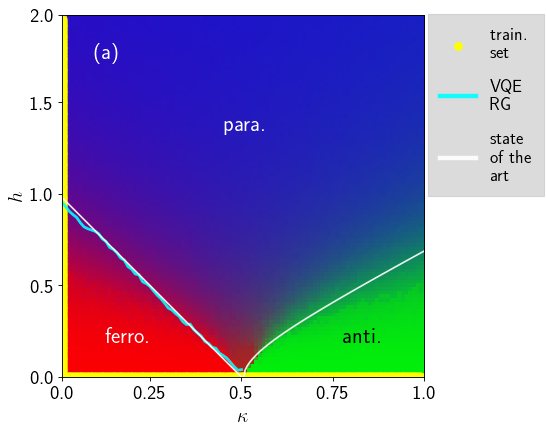

In [17]:
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents, train_index = lines, label = 'a', info=True)
plt.savefig('./classification_withinfo.svg')

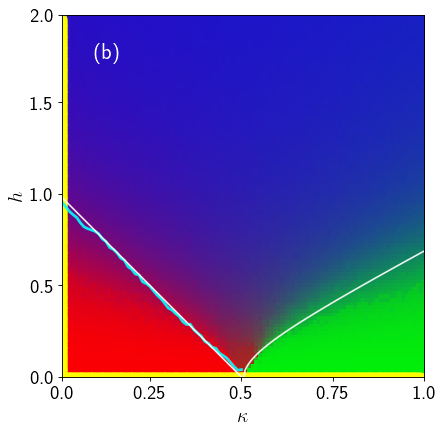

In [18]:
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents, train_index =lines, label = 'b', info=False)
plt.savefig('./classification_noinfo.svg')

In [ ]:
def show_QCNN_classificationANNNI(qcnnclass, hard_thr = True, lines = False, deltaeline = [], train_index = [], label = False, info = False):

    plt.figure(figsize=(8, 6), dpi=80)

    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    
    if hard_thr:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))
        c = []
        for pred in predictions:
            if (pred == [0,1]).all():
                c.append(0)
            elif (pred == [1,1]).all():
                c.append(1)
            elif (pred == [1,0]).all():
                c.append(2)
            else: c.append(3)

        phases = mpl.colors.ListedColormap(["lightcoral", "skyblue",
                                            "black", "palegreen"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,4), phases.N) 
        plt.imshow( np.rot90(np.reshape(c, (side, side) )), 
                                      cmap = phases, norm = norm)
    else:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return qml.probs([int(k) for k in qcnnclass.final_active_wires])
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(vcircuit(qcnnclass.vqe_params) )
        
        c = []
        
        # define color map 
        color_map = {1: np.array([255, 0, 0]), # red
                     2: np.array([0, 255, 0]), # green
                     3: np.array([0, 0, 255])} # blue
        
        rgb_probs = np.ndarray(shape=(side*side, 3), dtype=float)
        
        for i, pred in enumerate(predictions):
            rgb_probs[i] = [pred[1]*255,pred[2]*255,pred[3]*255]
        rgb_probs = np.rot90(np.reshape(rgb_probs, (side,side,3)) )/255
        
        plt.imshow( rgb_probs )
        
    plt.ylabel(r'$h$', fontsize=18)
    plt.xlabel(r'$\kappa$', fontsize=18)
    
    def getlines(func, xrange, side, color, res = 100, legendlabel = ''):
        xs = np.linspace(xrange[0], xrange[1], res)
        ys = func(xs)
        
        if legendlabel != '':
            plt.plot(side*xs -.5, side - ys*side/2 -.5, color = color, alpha=.9, label=legendlabel)
        else:
            plt.plot(side*xs -.5, side - ys*side/2 -.5, color = color, alpha=.9)
        
    def B2SA(x):
        return 1.05 * np.sqrt((x-.5)*(x-.1))
    
    def ferropara(x):
        return 1 - 2*x
    
    x = np.linspace(1, 0, side)
    y = np.linspace(0, 2, side)

    plt.xticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*1/4,2) for k in range(0,5)], fontsize=18)
    plt.yticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*2/4,2) for k in range(4,-1,-1)], fontsize=18)
        
    if len(train_index)>0:
        yshift = 1
        xshift = 0
        if len(train_index)==(2*side-1):
            yshift = -.5
            xshift = 1.5
        x_star, y_star = [], []
        for idx in train_index:
            x_star.append(idx//side - xshift)
            y_star.append(side - idx%side - yshift)
        plt.scatter(x_star, y_star, marker = 'o', color = 'yellow', s = 300, alpha =.95, label='train.\nset')
        plt.ylim(side-1,0)
        plt.xlim(0,side-1)

    if len(deltaeline)>0:
        plt.plot([side/2]*int(side/2) + (side/2) * deltaeline, color ='cyan', lw= 2.5, alpha=.9, label='VQE\nRG')

    getlines(B2SA, [.5,1], side, 'white', res = 100, legendlabel='state\nof the\nart')
    getlines(ferropara, [0,.5], side, 'white', res = 100)
    
    if label:
        plt.figtext(.28, .79, '('+label+')', color = 'white', fontsize=20)

    if info:
        plt.text(side*.5, side*.3, 'para.', color = 'white', fontsize = 20, ha='center', va='center')
        plt.text(side*.18, side*.88, 'ferro.', color = 'white', fontsize = 20, ha='center', va='center')
        plt.text(side*.82, side*.88, 'anti.', color = 'black', fontsize = 20, ha='center', va='center')

        leg = plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=16, facecolor='lightgray', markerscale=.4, labelspacing=1)
        leg.get_frame().set_boxstyle('Square')

        # change the line width for the legend
        for line in leg.get_lines():
            line.set_linewidth(4.0)